In [5]:


import numpy as np
import math
import random
from helper_methods_cy import *
import matplotlib.pyplot as plt



class Simulation:
    
    """
    Class containing the main methods to run the simulation
    """
    
    def __init__(self,L, rel_tol = 0.1, sweeps = 0):
        
        """
        Class initiator
        
        Inputs:
                L <int>: Size of ribosome
                rel_tol <float>: Maximum Relative current difference to determine steady state
                sweeps <int>: Number of sweeps to the the simulation for. (Both to reach
                                steady state and after)
                                
        """
        
        self.L = L
        self.sweeps = sweeps
        self.rel_tol = rel_tol
        
        
        
    def ExtractRates(self,file_name,alpha,beta):
        
         
        """
        Extract hopping rates from the file.
        
        Inputs:
                file_name <string>: Path/Name of file containing the rates
                alpha <float>: Inisitiation Rate
                beta <float>: Exit rate
                                
        """
    
        self.w_ = Extract_hopping_rates(open(file_name, 'r'), alpha,beta)
        self.LEN = len(self.w_) - 1
        self.RUNS = self.sweeps * self.LEN
        
    def ChangeAlpha(self,alpha):
        """
        Change the inisitiation rate
        
        Inputs:
                alpha <float>: Inisitiation Rate
                                
        """
        
        self.w_[0] = alpha
        
        return
    

    def Reach_steady(self):
        
        """
        Reach the steady state for the simulation
                                
        """
        
        # Initialize lists needed for simulation
        
        self.pos_jump_ = np.zeros(1,dtype=int) # List of ribisome positions that can possible jump in next step
        self.pos_w_ = np.array([self.w_[0]]) # List of hopping rates for ribosomes that can jump
        self.rib_pos_ = np.array([], dtype=int) # List of positions of ribosomes
        
        # Initialize variables of simulation
        t = 0
        no_rib_enter = 0
        no_rib_exit = 0
        runs = 0
        entry_current_new = 0
        self.a = self.w_[0]
        
        while True:
            
            #Run simulation step
            t, enter, exit, move =  self.__Sim_run(t)
            
            runs += 1
            
            #Update number of ribosomes entered and exited
            if enter:
                no_rib_enter += 1
            elif exit:
                no_rib_exit += 1
              
            if runs == 1:
                entry_current_new = no_rib_enter/t
            
         
            
            if self.RUNS == 0 and ((runs/self.LEN)%500) == 0:
               
                #Calculate currents
                entry_current_old = entry_current_new
                entry_current_new = no_rib_enter/t
                 
                # Check if Steady state reached if runs == 0
                if self.__checkSteadyState(entry_current_old,entry_current_new):
                
                    break
            
            # If runs != 0 then stop if number of runs reached
            elif self.RUNS !=0 and runs >=self.RUNS:
                
                break
            
            
        # If runs == 0, set runs of the sumulation as the runs it took to reach steady state   
        if self.RUNS == 0:
            
            self.RUNS = runs
            
    

    def Run_Sim(self):
        
        """
        Run simulation after reaching steady state
                                
        """
        #Run simulation
        
        #Initialize simulation variables
        self.TIME = 0
        self.current = 0
        self.rho_ = np.zeros(self.LEN)
        
        no_rib_enter = 0
        
        
        # Run simulation
        for i in range(self.RUNS):
            
            self.TIME,enter, *aux = self.__Sim_run(self.TIME,True)
            
            if enter:
                
                no_rib_enter += 1
            
        
        # Calculate current
        self.current = no_rib_enter/self.TIME
        # Calculate density profile
        self.rho_ = self.rho_/self.TIME
        self.rho_ = self.rho_[1:]
        


    def __Sim_run(self, t = 0, steady_reached = False):
        
        enter = False
        exit = False
        move = False
        
        
        tau = Get_tau(self.a)
        
        t += tau
    
        index = Get_mu(self.pos_w_,self.a)
        

        
        if steady_reached:
            
            self.__calcDensity(tau)
    
        
        if self.pos_jump_[index] == 0:
            

        
            self.rib_pos_ = np.insert(self.rib_pos_,0,2)
            self.a -= self.w_[0]
            
            if len(self.rib_pos_) > 1:
                if self.rib_pos_[1] > self.L+2: 
                    self.pos_jump_[index] = 2
                    self.pos_w_[index] = self.w_[2]
                    self.a += self.w_[2]
                elif self.rib_pos_[1] <= self.L+2:
                    self.pos_jump_= np.delete(self.pos_jump_, index)
                    self.pos_w_= np.delete(self.pos_w_, index)
                    
            else:
                self.pos_jump_[index] = 2
                self.pos_w_[index] = self.w_[2]
                self.a += self.w_[2]
                
            enter = True
        
        elif self.pos_jump_[index] == self.LEN:
        
            self.rib_pos_ = np.delete(self.rib_pos_, -1)
            self.a -= self.w_[-1]
            
            if len(self.rib_pos_) >= 1 and self.rib_pos_[-1] == self.LEN-self.L:
                self.pos_jump_[index] = self.rib_pos_[-1]
                self.pos_w_[index] = self.w_[self.rib_pos_[-1]]
                self.a += self.w_[self.rib_pos_[-1]]
            
            else:
                self.pos_jump_= np.delete(self.pos_jump_, index)
                self.pos_w_= np.delete(self.pos_w_, index)
                
            exit = True
        
        else:
        
            rib_pos_index = np.where(self.rib_pos_ == self.pos_jump_[index])
            rib_pos_index = rib_pos_index[0][0]
            self.rib_pos_[rib_pos_index] += int(1)
            self.a -= self.pos_w_[index]
            
            
            if len(self.rib_pos_) > rib_pos_index+1:
                if self.rib_pos_[rib_pos_index+1] - self.rib_pos_[rib_pos_index] > self.L:
                    self.pos_jump_[index] = self.rib_pos_[rib_pos_index]
                    self.pos_w_[index] = self.w_[self.rib_pos_[rib_pos_index]]
                    self.a += self.w_[self.rib_pos_[rib_pos_index]]
                else:
                    self.pos_jump_= np.delete(self.pos_jump_, index)
                    self.pos_w_= np.delete(self.pos_w_, index)
            else:
                
                self.pos_jump_[index] = self.rib_pos_[rib_pos_index]
                self.pos_w_[index] = self.w_[self.rib_pos_[rib_pos_index]]
                self.a += self.w_[self.rib_pos_[rib_pos_index]]
                
            if rib_pos_index != 0 and self.rib_pos_[rib_pos_index] - self.rib_pos_[rib_pos_index-1] == self.L+1 :
                
                self.pos_jump_ = np.insert(self.pos_jump_,index,self.rib_pos_[rib_pos_index-1]) 
                self.pos_w_ = np.insert(self.pos_w_,index,self.w_[self.rib_pos_[rib_pos_index-1]])
                self.a += self.w_[self.rib_pos_[rib_pos_index-1]]
                
            elif rib_pos_index == 0 and self.rib_pos_[rib_pos_index] == self.L+2:
                self.pos_jump_ = np.insert(self.pos_jump_,0,0) 
                self.pos_w_ = np.insert(self.pos_w_,0,self.w_[0])
                self.a += self.w_[0]
                
            move = True
    
 
        return t, enter, exit, move



    def __checkSteadyState(self,entry_current_old,entry_current_new):
        
        if abs((entry_current_old - entry_current_new)*100/entry_current_old) < self.rel_tol:
            
            return True
        
        else: 
            
            return False

    def __calcDensity(self,tau):
        
        for i in self.rib_pos_:
            
            self.rho_[i-1] += tau
        
        return
   
    def getTot_den(self):
        
        return np.sum(self.rho_)/len(self.rho_)








In [6]:
sim = Simulation(1 , sweeps = 5000) 
# file_name = '../'+'elongation-rates/'+'YBL108W_rates.dat'
file_name = '../kvalue_dummy.dat'
sim.ExtractRates(file_name,0.1,0.9)

In [8]:
%%timeit
sim.Reach_steady()
sim.Run_Sim()

1 loop, best of 3: 38 s per loop


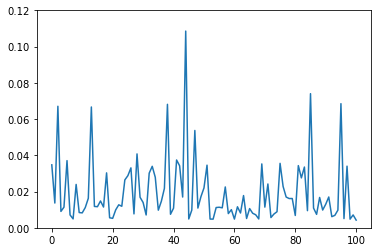

In [121]:
plt.plot(np.arange(0,len(sim1.rho_)),sim1.rho_)
plt.ylim(0,0.12)  
plt.show()